# 2. Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lazypredict.Supervised import LazyRegressor
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


age (Yaş): Sigortalı bireylerin yaşları.
sex (Cinsiyet): Sigortalı bireylerin cinsiyetleri (female: kadın, male: erkek).
bmi (Vücut Kitle İndeksi): Sigortalı bireylerin vücut kitle indeksi değerleri.
children (Çocuk Sayısı): Sigortalı bireylerin sahip olduğu çocuk sayısı.
smoker (Sigara İçici): Sigortalı bireylerin sigara içip içmediği (yes: içiyor, no: içmiyor).
region (Bölge): Sigortalı bireylerin yaşadığı coğrafi bölgeler.
charges (Ücretler): Sigortalı bireylerin sağlık sigortası prim ücretleri.

Bu veri seti, sağlık sigortası prim ücretlerini etkileyebilecek farklı faktörleri incelemek için kullanılabilir. Örneğin, yaş, cinsiyet, vücut kitle indeksi, çocuk sayısı, sigara içme alışkanlığı ve yaşadıkları bölge gibi değişkenlerin sağlık sigortası ücretlerine nasıl etki edebileceğini anlamak için analizler yapılabilir.

In [2]:
def check_df(dataframe, head=5):
    print("**************************************** Shape ****************************************")
    print(dataframe.shape)
    print("**************************************** Dtypes ****************************************")
    print(dataframe.dtypes)
    print("**************************************** Head ****************************************")
    print(dataframe.head(head))
    print("**************************************** Tail ****************************************")
    print(dataframe.tail(head))
    print("**************************************** N/A Values *************************************")
    print(dataframe.isnull().sum())
    print("******************** Quantiles (Sayisal Değişken Dağilimi) ******************************")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
check_df(data)

**************************************** Shape ****************************************
(1338, 7)
**************************************** Dtypes ****************************************
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
**************************************** Head ****************************************
   age     sex   bmi  children smoker     region  charges
0   19  female 27.90         0    yes  southwest 16884.92
1   18    male 33.77         1     no  southeast  1725.55
2   28    male 33.00         3     no  southeast  4449.46
3   33    male 22.70         0     no  northwest 21984.47
4   32    male 28.88         0     no  northwest  3866.86
**************************************** Tail ****************************************
      age     sex   bmi  children smoker     region  charges
1333   50    male 30.97         3     no  northwest 10600.55
1334   18  fema

# 3. Perform An Exploratory Data Analysis

### a) Examine the distribution of Bmi (Body Mass Index)

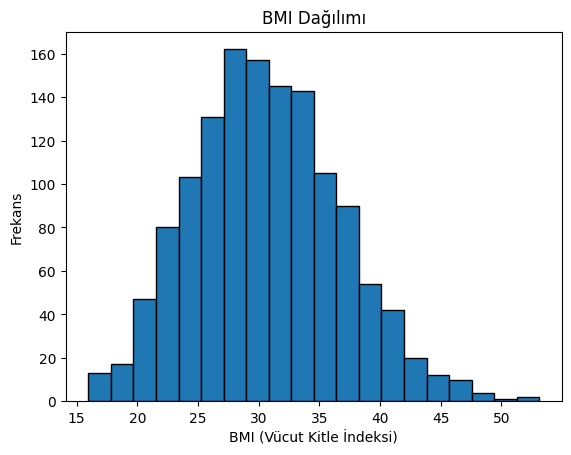

In [4]:
# "bmi" kolonundaki verileri alın
bmi_values = data["bmi"]

# Histogram oluşturma
plt.hist(bmi_values, bins=20, edgecolor='black')  # 20 aralığa sahip bir histogram oluşturuluyor
plt.xlabel('BMI (Vücut Kitle İndeksi)')
plt.ylabel('Frekans')
plt.title('BMI Dağılımı')
plt.show()

In [5]:
# Merkezi Tendans Ölçülerini İnceleme
mean_bmi = np.mean(bmi_values)
median_bmi = np.median(bmi_values)

print("Ortalama BMI:", mean_bmi)
print("Medyan BMI:", median_bmi)

Ortalama BMI: 30.66339686098655
Medyan BMI: 30.4


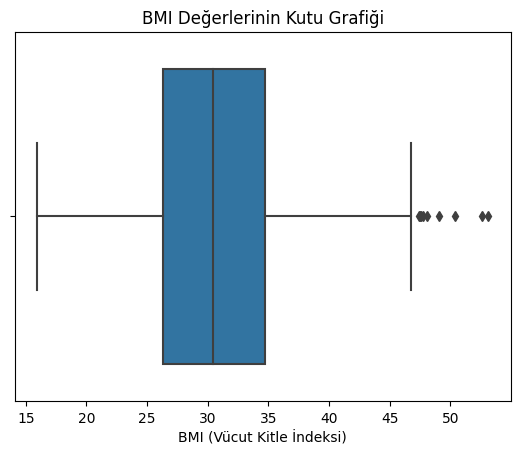

In [6]:
# Çeyreklikler ve Aykırı Değerler:
sns.boxplot(x=bmi_values)
plt.xlabel('BMI (Vücut Kitle İndeksi)')
plt.title('BMI Değerlerinin Kutu Grafiği')
plt.show()

In [7]:
# İstatistiksel testler için scipy kütüphanesini kullanabilirsiniz. Örneğin, Shapiro-Wilk normalite testi:
stat, p = shapiro(bmi_values)
print("Test İstatistiği:", stat)
print("p-değer:", p)

if p > 0.05:
    print("Veri normal dağılıma uyar.")
else:
    print("Veri normal dağılıma uymaz.")

Test İstatistiği: 0.9938861727714539
p-değer: 2.6033414542325772e-05
Veri normal dağılıma uymaz.


Not: Test istatistiği 0.9938 ve p-değeri çok küçük bir değer (2.60e-05) olarak bulunmuş. Bu sonuçlar, veri setinizin normal bir dağılıma uymadığını gösteriyor. Çünkü p-değeri 0.05 anlamlılık düzeyinden çok daha küçük. Bu, veri setinizin normal dağılıma uymadığına dair istatistiksel olarak anlamlı bir kanıt sağlar.

### b) Examine the relationship between “smoker” and “charges”

In [8]:
grouped_data = data.groupby("smoker")["charges"].mean()
print(grouped_data)


smoker
no     8434.27
yes   32050.23
Name: charges, dtype: float64


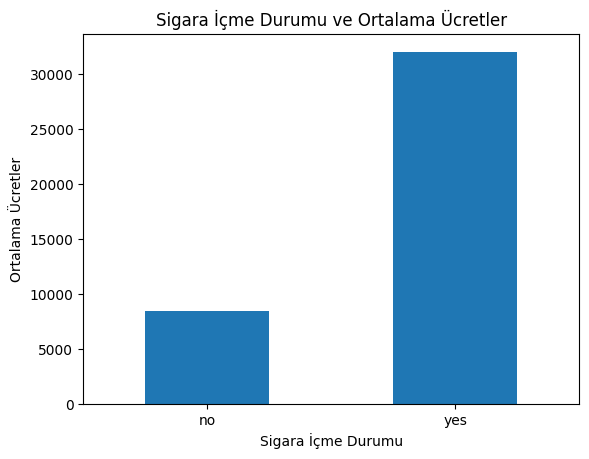

In [9]:
grouped_data.plot(kind="bar")
plt.xlabel("Sigara İçme Durumu")
plt.ylabel("Ortalama Ücretler")
plt.title("Sigara İçme Durumu ve Ortalama Ücretler")
plt.xticks(rotation=0)
plt.show()

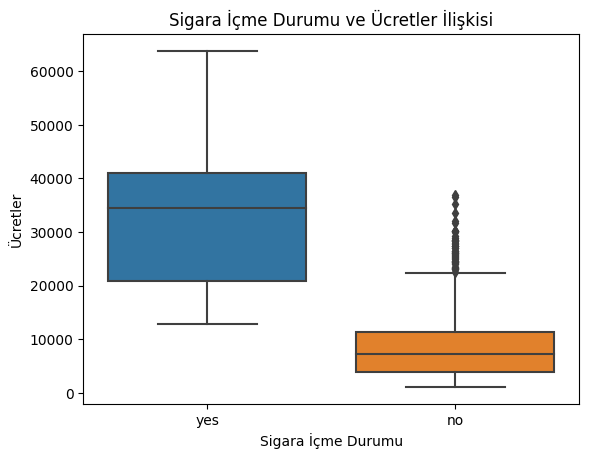

In [10]:
sns.boxplot(x="smoker", y="charges", data=data)
plt.xlabel("Sigara İçme Durumu")
plt.ylabel("Ücretler")
plt.title("Sigara İçme Durumu ve Ücretler İlişkisi")
plt.show()

### c) Examine the relationship between “smoker” and “region”.

In [11]:
grouped_data = data.groupby(["smoker", "region"]).size().reset_index(name="count")
print(grouped_data)


  smoker     region  count
0     no  northeast    257
1     no  northwest    267
2     no  southeast    273
3     no  southwest    267
4    yes  northeast     67
5    yes  northwest     58
6    yes  southeast     91
7    yes  southwest     58


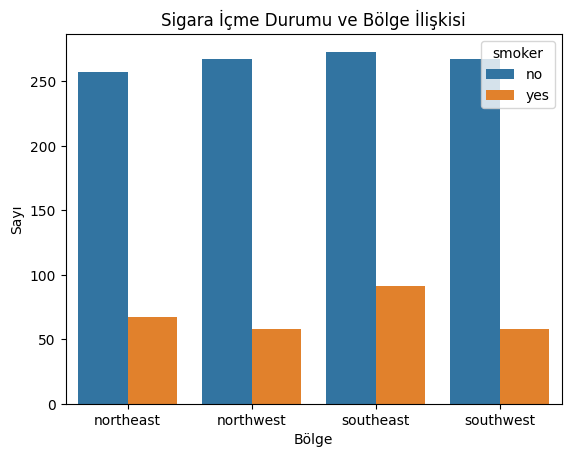

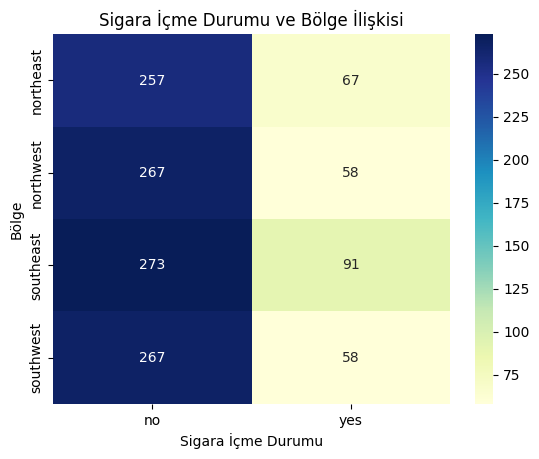

In [12]:
# Veriyi "smoker" ve "region" sütunlarına göre gruplandırın ve sayılarını hesaplayın
grouped_data = data.groupby(["smoker", "region"]).size().reset_index(name="count")

# Çubuk grafik
sns.barplot(x="region", y="count", hue="smoker", data=grouped_data)
plt.xlabel("Bölge")
plt.ylabel("Sayı")
plt.title("Sigara İçme Durumu ve Bölge İlişkisi")
plt.xticks(rotation=0)
plt.show()

# Isı haritası için veriyi dönüştürün
pivot_data = grouped_data.pivot_table(index="region", columns="smoker", values="count")
pivot_data = pivot_data.fillna(0)  # Eksik değerleri 0 ile doldurun

# Isı haritası
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.xlabel("Sigara İçme Durumu")
plt.ylabel("Bölge")
plt.title("Sigara İçme Durumu ve Bölge İlişkisi")
plt.show()

### d) Examine the relationship between “bmi” and “sex”.

In [13]:
grouped_data = data.groupby("sex")["bmi"].mean()
print(grouped_data)


sex
female   30.38
male     30.94
Name: bmi, dtype: float64


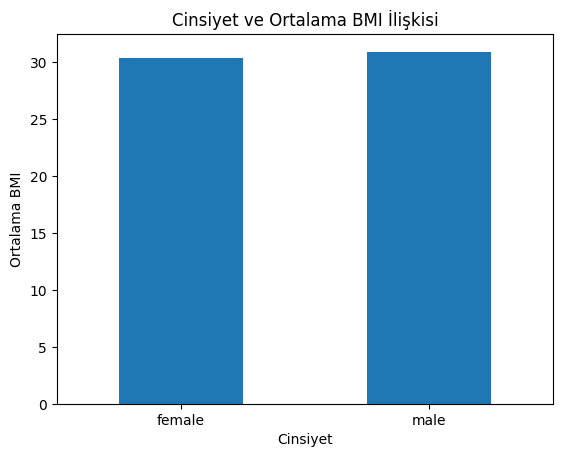

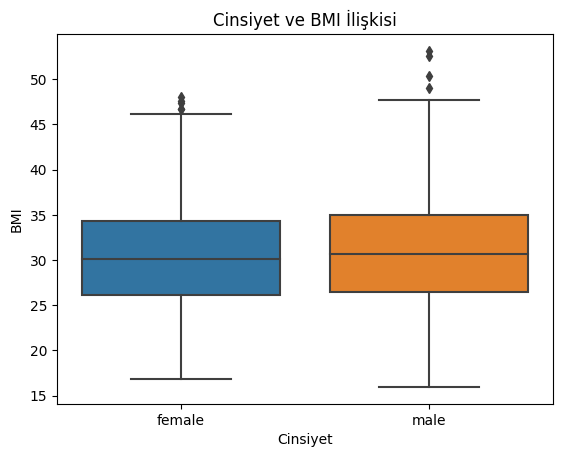

In [14]:
# Çubuk grafik
grouped_data.plot(kind="bar")
plt.xlabel("Cinsiyet")
plt.ylabel("Ortalama BMI")
plt.title("Cinsiyet ve Ortalama BMI İlişkisi")
plt.xticks(rotation=0)
plt.show()

# Kutu grafiği
sns.boxplot(x="sex", y="bmi", data=data)
plt.xlabel("Cinsiyet")
plt.ylabel("BMI")
plt.title("Cinsiyet ve BMI İlişkisi")
plt.show()

### e) Find the "region" with the most "children".

In [15]:
grouped_data = data.groupby("region")["children"].sum()
print(grouped_data)


region
northeast    339
northwest    373
southeast    382
southwest    371
Name: children, dtype: int64


In [16]:
most_children_region = grouped_data.idxmax()
print("En fazla çocuğa sahip bölge:", most_children_region)


En fazla çocuğa sahip bölge: southeast


### f) Examine the relationship between “age” and “bmi”.

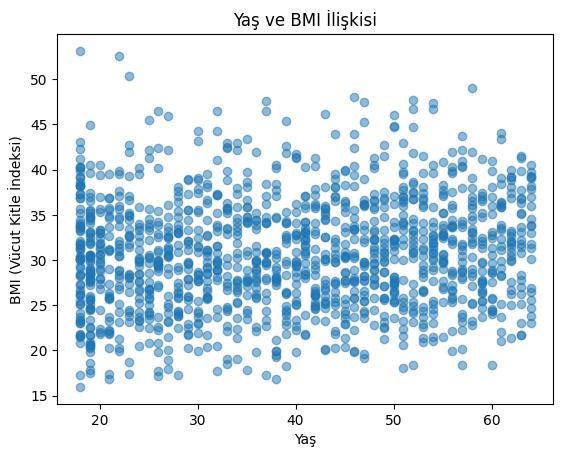

In [17]:
plt.scatter(data["age"], data["bmi"], alpha=0.5)
plt.xlabel("Yaş")
plt.ylabel("BMI (Vücut Kitle İndeksi)")
plt.title("Yaş ve BMI İlişkisi")
plt.show()

In [18]:
correlation = data["age"].corr(data["bmi"])
print("Yaş ve BMI Korelasyon Katsayısı:", correlation)


Yaş ve BMI Korelasyon Katsayısı: 0.10927188154853519


Not: Sonuç olarak korelasyon katsayısı 0.109 olarak bulunmuş. Bu, "age" (yaş) ile "bmi" (vücut kitle indeksi) arasında zayıf bir pozitif korelasyon olduğunu gösterir. Ancak, korelasyonun büyüklüğü göz önüne alındığında bu ilişkinin pek güçlü olmadığını söyleyebiliriz.

Yani, bu verilere göre yaş ile vücut kitle indeksi arasında çok zayıf bir pozitif ilişki olduğunu söyleyebilirsiniz. Ancak, bu korelasyonun pratikte anlamlı bir etki boyutuna sahip olup olmadığını değerlendirmek için daha fazla analiz yapmak gerekebilir.

###  g) Examine the relationship between “bmi” and “children”.

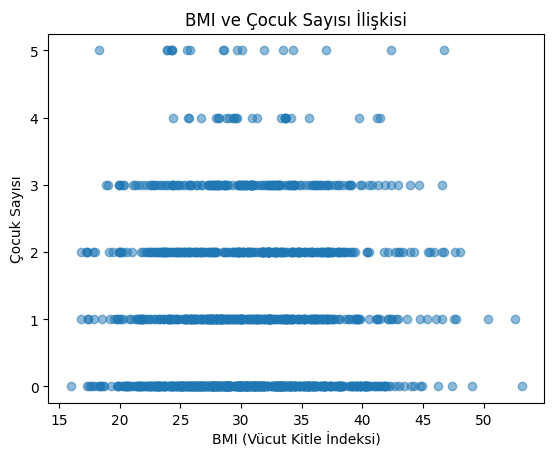

In [19]:
plt.scatter(data["bmi"], data["children"], alpha=0.5)
plt.xlabel("BMI (Vücut Kitle İndeksi)")
plt.ylabel("Çocuk Sayısı")
plt.title("BMI ve Çocuk Sayısı İlişkisi")
plt.show()

In [20]:
correlation = data["bmi"].corr(data["children"])
print("BMI ve Çocuk Sayısı Korelasyon Katsayısı:", correlation)


BMI ve Çocuk Sayısı Korelasyon Katsayısı: 0.012758900820673833


Not: Sonuç olarak korelasyon katsayısı 0.01275 olarak bulunmuş. Bu, "bmi" (vücut kitle indeksi) ile "children" (çocuk sayısı) arasında çok zayıf bir pozitif korelasyon olduğunu gösterir. Yani, bu iki değişken arasında neredeyse hiçbir ilişki olmadığını söyleyebilirsiniz.

Bu durumda, "bmi" ve "children" arasında istatistiksel olarak anlamlı bir ilişki olmadığını söyleyebiliriz.

### h) Is there an outlier in the "bmi" variable? Please review.

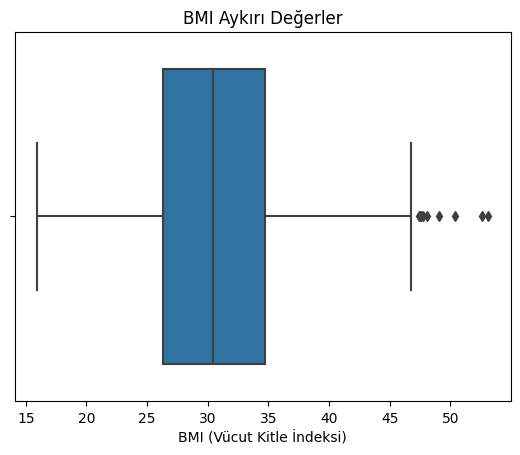

In [21]:
# Kutu grafiği
sns.boxplot(x=data["bmi"])
plt.xlabel("BMI (Vücut Kitle İndeksi)")
plt.title("BMI Aykırı Değerler")
plt.show()

In [22]:
Q1 = data["bmi"].quantile(0.25)
Q3 = data["bmi"].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers = data[(data["bmi"] < lower_limit) | (data["bmi"] > upper_limit)]
print("Aykırı Değerler:")
print(outliers)


Aykırı Değerler:
      age     sex   bmi  children smoker     region  charges
116    58    male 49.06         0     no  southeast 11381.33
286    46  female 48.07         2     no  northeast  9432.93
401    47    male 47.52         1     no  southeast  8083.92
543    54  female 47.41         0    yes  southeast 63770.43
847    23    male 50.38         1     no  southeast  2438.06
860    37  female 47.60         2    yes  southwest 46113.51
1047   22    male 52.58         1    yes  southeast 44501.40
1088   52    male 47.74         1     no  southeast  9748.91
1317   18    male 53.13         0     no  southeast  1163.46


Örneğin, "bmi" değeri 53.13 olan bir 18 yaşındaki erkek, "bmi" değeri 52.58 olan bir 22 yaşındaki erkek ve "bmi" değeri 50.38 olan bir 23 yaşındaki erkek gibi değerler aykırı görünüyor. Bu değerler, genel dağılımdan büyük ölçüde sapmış gibi görünüyor.
Sonuç olarak, bu aykırı değerlerin "bmi" değişkeninde bulunduğunu ve bu değerlerin geri kalan veri setinden önemli ölçüde sapmış olduğu görülüyor

### i) Examine the relationship between “bmi” and “charges”.

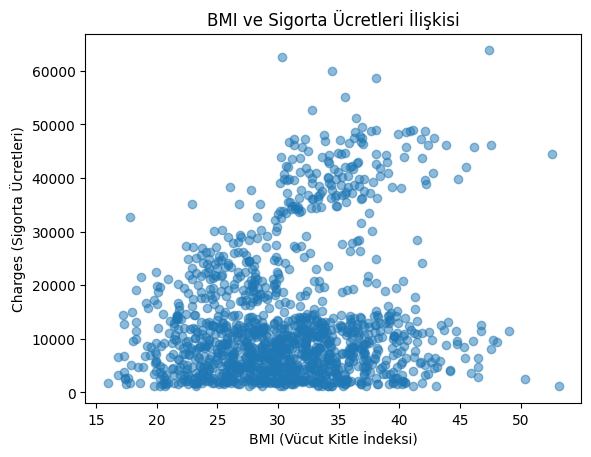

In [23]:
plt.scatter(data["bmi"], data["charges"], alpha=0.5)
plt.xlabel("BMI (Vücut Kitle İndeksi)")
plt.ylabel("Charges (Sigorta Ücretleri)")
plt.title("BMI ve Sigorta Ücretleri İlişkisi")
plt.show()

In [24]:
correlation = data["bmi"].corr(data["charges"])
print("BMI ve Sigorta Ücretleri Korelasyon Katsayısı:", correlation)


BMI ve Sigorta Ücretleri Korelasyon Katsayısı: 0.1983409688336289


Özetle, "bmi" ile "charges" arasında zayıf bir pozitif ilişki olduğunu söyleyebiliriz. Ancak, bu ilişkinin büyüklüğü çok düşük olduğundan, "bmi" değeri arttıkça "charges" değerinin büyük bir değişim göstermediğini söyleyebiliriz. 

### j) Examine the relationship between “region”, “smoker” and “bmi” using bar plot.

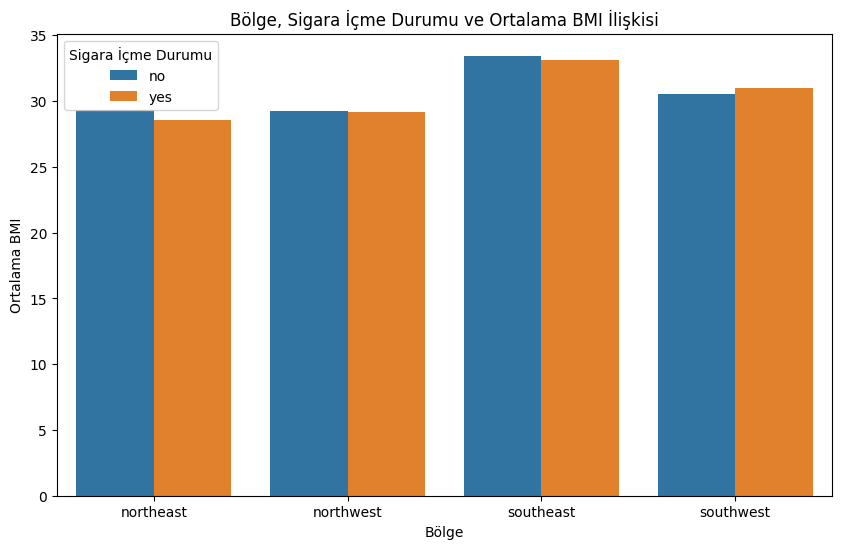

In [25]:
# Veriyi "region", "smoker" ve "bmi" sütunlarına göre gruplandırma ve ortalama "bmi" değerlerini hesaplama
grouped_data = data.groupby(["region", "smoker"])["bmi"].mean().reset_index()

# Çubuk grafiği oluşturma
plt.figure(figsize=(10, 6))
sns.barplot(x="region", y="bmi", hue="smoker", data=grouped_data)
plt.xlabel("Bölge")
plt.ylabel("Ortalama BMI")
plt.title("Bölge, Sigara İçme Durumu ve Ortalama BMI İlişkisi")
plt.xticks(rotation=0)
plt.legend(title="Sigara İçme Durumu")
plt.show()

In [26]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


# 4. Data Preprocessing

In [27]:
# One-Hot Encoding için veri setini kopyalama
encoded_data_onehot = data.copy()

In [28]:
# One-Hot Encoding işlemi
encoded_data_onehot = pd.get_dummies(encoded_data_onehot, columns=["sex", "smoker", "region"], drop_first=True)

print(encoded_data_onehot.head())


   age   bmi  children  charges  sex_male  smoker_yes  region_northwest  region_southeast  region_southwest
0   19 27.90         0 16884.92     False        True             False             False              True
1   18 33.77         1  1725.55      True       False             False              True             False
2   28 33.00         3  4449.46      True       False             False              True             False
3   33 22.70         0 21984.47      True       False              True             False             False
4   32 28.88         0  3866.86      True       False              True             False             False


In [29]:
encoded_data_numeric = encoded_data_onehot.copy()

# True-False değerleri 1-0 olarak dönüştürme
encoded_data_numeric = encoded_data_numeric.astype(int)

print(encoded_data_numeric.head())


   age  bmi  children  charges  sex_male  smoker_yes  region_northwest  region_southeast  region_southwest
0   19   27         0    16884         0           1                 0                 0                 1
1   18   33         1     1725         1           0                 0                 1                 0
2   28   33         3     4449         1           0                 0                 1                 0
3   33   22         0    21984         1           0                 1                 0                 0
4   32   28         0     3866         1           0                 1                 0                 0


In [30]:
encoded_data_numeric.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27,0,16884,0,1,0,0,1
1,18,33,1,1725,1,0,0,1,0
2,28,33,3,4449,1,0,0,1,0
3,33,22,0,21984,1,0,1,0,0
4,32,28,0,3866,1,0,1,0,0


In [31]:
X = encoded_data_numeric.drop("charges", axis=1)  # Bağımsız değişkenler
y = encoded_data_numeric["charges"]  # Hedef değişken
# Veriyi train ve test setlere ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Özellikleri ölçekleme (scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Ölçeklenmiş verileri DataFrame'e dönüştürme
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Aynı şekilde y_train_scaled ve y_test_scaled'ı da gerekiyorsa DataFrame'e dönüştürebilirsiniz
# Ancak hedef değişkenin ölçeklenmesinin gerekliliğini değerlendirmeniz önemlidir.

# 5. Model Selection

In [34]:
# LazyPredict kullanarak modelleri değerlendirme
regressor = LazyRegressor(predictions=True)
models = regressor.fit(X_train_scaled_df, X_test_scaled_df, y_train, y_test)

print(models)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [01:07<00:00,  1.60s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 1070, number of used features: 8
[LightGBM] [Info] Start training from score 13345.596262
(                               Adjusted R-Squared  R-Squared      RMSE  Time Taken
Model                                                                             
GradientBoostingRegressor                    0.87       0.88   4347.97        0.23
LGBMRegressor                                0.86       0.87   4545.64        0.36
HistGradientBoostingRegressor                0.86       0.87   4564.52        1.26
RandomForestRegressor                        0.85       0.86   4714.44        0.81
BaggingRegressor                             0.84       0.84   4912.73        0.16
ExtraTre

### Examine the performances of the selected models using cross validation.

In [35]:
from sklearn.model_selection import cross_val_score
# GradientBoostingRegressor modeli oluşturun
model = GradientBoostingRegressor()

# Cross-validation yaparak R^2 skoru kullanarak modelin performansını değerlendirin
# cv parametresi, kaç katlı cross-validation yapılacağını belirtir
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Sonuçları yazdırın
print("Cross-Validation Skorları:", scores)
print("Ortalama R^2 Skoru:", scores.mean())

Cross-Validation Skorları: [0.87587741 0.79814007 0.89496451 0.8537818  0.86523693]
Ortalama R^2 Skoru: 0.8576001417469794


# 6. Hyper-parameter Optimization

In [36]:
# GradientBoostingRegressor modelini oluşturma
model = GradientBoostingRegressor()

# Modeli eğitme
model.fit(X_train_scaled_df, y_train)

# Modeli kullanarak tahmin yapma
y_pred = model.predict(X_test_scaled_df)

# Mean Squared Error (MSE) hesaplama
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 18904828.29058366


In [37]:
# Grid Search için olası hiperparametre değerleri
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Grid Search modeli oluşturma
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5)

# Grid Search ile en iyi parametreleri bulma
grid_search.fit(X_train_scaled_df, y_train)

# En iyi parametreleri ve skorları yazdırma
print("En İyi Parametreler:", grid_search.best_params_)
print("En İyi Skor:", grid_search.best_score_)

En İyi Parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
En İyi Skor: 0.8485989174743848


Default => GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0,
                          criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                          min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                          min_impurity_split=None, init=None, random_state=None, max_features=None,
                          alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated',
                          validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)


# 7. Model Evaluation

In [38]:
# GradientBoostingRegressor modelini oluşturma
model = GradientBoostingRegressor()

# Modeli eğitme
model.fit(X_train_scaled_df, y_train)

# Modeli kullanarak tahmin yapma
y_pred = model.predict(X_test_scaled_df)

# Mean Squared Error (MSE) hesaplama
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Mean Absolute Error (MAE) hesaplama
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R2) Score hesaplama
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

Mean Squared Error (MSE): 18904828.290583655
Mean Absolute Error (MAE): 2466.6877551449243
R-squared (R2) Score: 0.878228528426491
